In [1]:
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation

In [3]:
from config import config_vars

config_vars

{'augment_images': False,
 'boundary_boost_factor': 1,
 'boundary_size': 2,
 'cell_min_size': 16,
 'create_split_files': False,
 'dir_boundary_labels': '/data1/image-segmentation/BBBC022/unet/x_split_25/',
 'dir_images_normalized_8bit': '/data1/image-segmentation/BBBC022/unet/y_split_25/',
 'dir_raw_annotations': '/data1/image-segmentation/BBBC022/new_renamed_annotations/',
 'dir_raw_images': '/data1/image-segmentation/BBBC022/raw_images/',
 'dir_root': '/data1/image-segmentation/BBBC022/',
 'dir_test': '/data1/image-segmentation/BBBC022/unet/split_25/test/',
 'dir_training': '/data1/image-segmentation/BBBC022/unet/split_25/training/',
 'dir_validation': '/data1/image-segmentation/BBBC022/unet/split_25/validation/',
 'distort': 5,
 'max_training_images': 25,
 'min_nucleus_size': 25,
 'n_augmentations': 10,
 'n_points': 16,
 'path_files_test': '/data1/image-segmentation/BBBC022/test.txt',
 'path_files_training': '/data1/image-segmentation/BBBC022/training.txt',
 'path_files_validation':

In [4]:
base_dir = "/data1/image-segmentation/BBBC022/"

dir_gtruth = base_dir + "new_renamed_annotations/"

tag = "04"

dilation_parameter = 3

ref_out_dir_label = base_dir + "unet/split/test/x/0/"

#out_dir_label = base_dir + "unet/experiments/" + tag + "/out/segm/" # unet
#out_dir_label = base_dir + "raw_cp_segmentations/" # cellprofiler
out_dir_label = "/data1/image-segmentation/cp3_output_2018_02_02/mask/"
#out_dir_label = base_dir + "deepcell/validation_labeled_matrices/2pxSingleModel/" #deepcell

In [5]:
def show(ground_truth, prediction, IOU, threshold=0.5, image_name="N"):
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

In [6]:
def compute_results(ground_truth, prediction, results, image_name):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    show(ground_truth, prediction, IOU, image_name=image_name)

    # Calculate precision at all thresholds
    for t in np.arange(0.5, 1.0, 0.05):
        p = utils.evaluation.precision_at(t, IOU)
        res = {"Image": image_name, "Threshold": t, "Precision": p}
        row = len(results)
        results.loc[row] = res
        
    return results

In [7]:
def get_false_negatives(ground_truth, prediction, results, image_name, threshold=0.7):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)

    true_objects = len(np.unique(ground_truth))
    if true_objects <= 1:
        return results
        
    area_true = np.histogram(ground_truth, bins=true_objects)[0][1:]
    true_objects -= 1
    
    # Identify False Negatives
    matches = IOU > threshold
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects

    data = np.asarray([ 
        area_true.copy(), 
        np.array(false_negatives, dtype=np.int32)
    ])

    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Negative"])])
        
    return results

In [8]:
def get_splits_and_merges(ground_truth, prediction, results, image_name):
    
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    matches = IOU > 0.3
    merges = np.sum(matches, axis=0) > 1
    splits = np.sum(matches, axis=1) > 1
    r = {"Image_Name":image_name, "Merges":np.sum(merges), "Splits":np.sum(splits)}
    results.loc[len(results)+1] = r
    return results

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


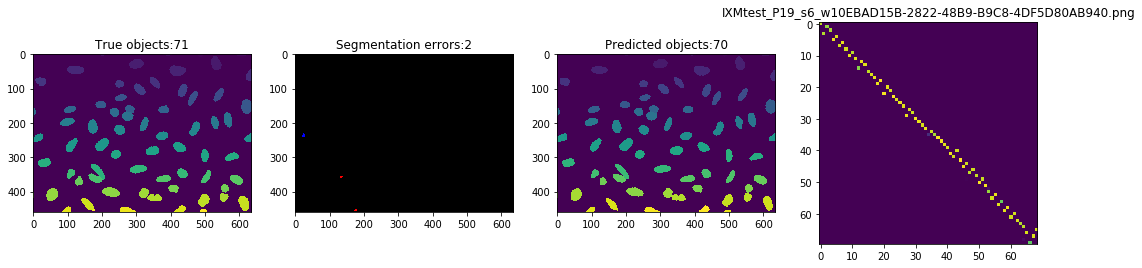

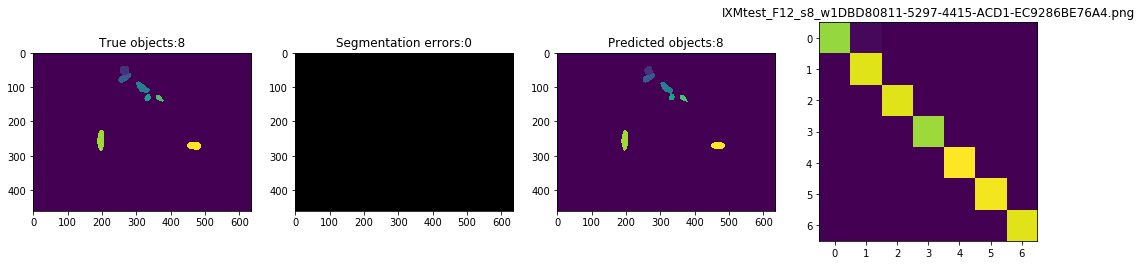

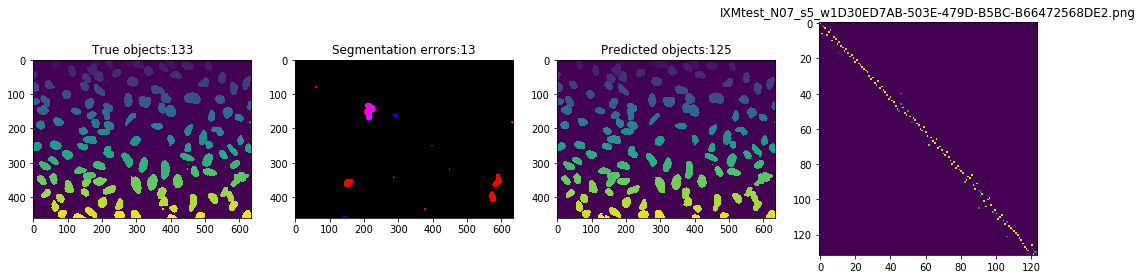

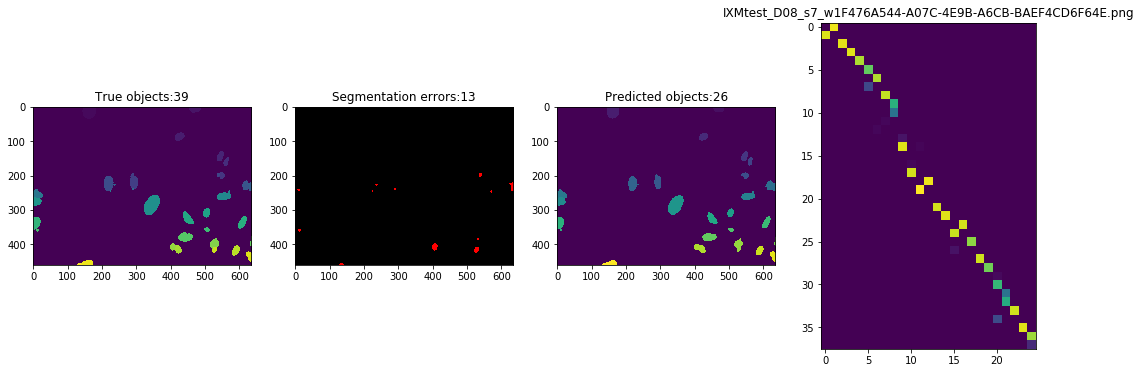

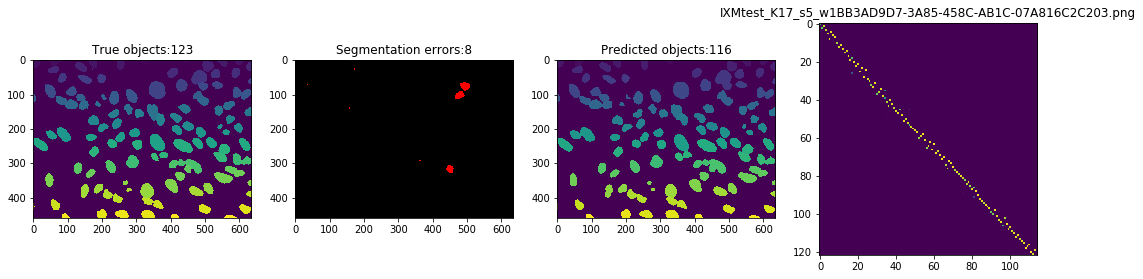

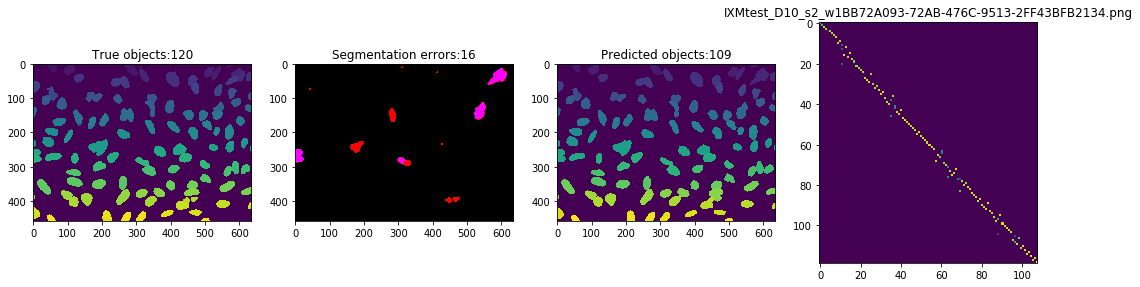

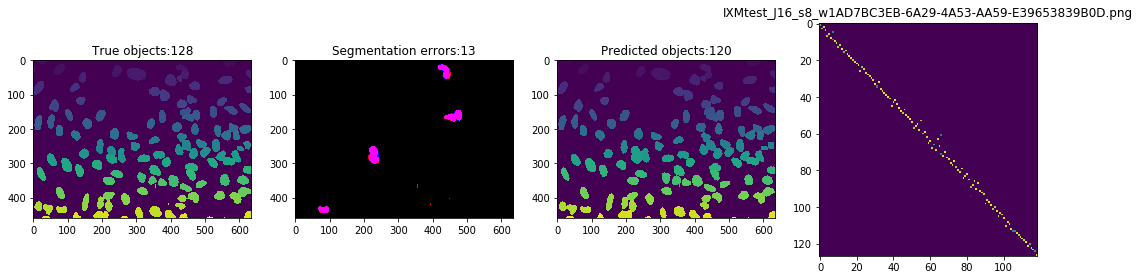

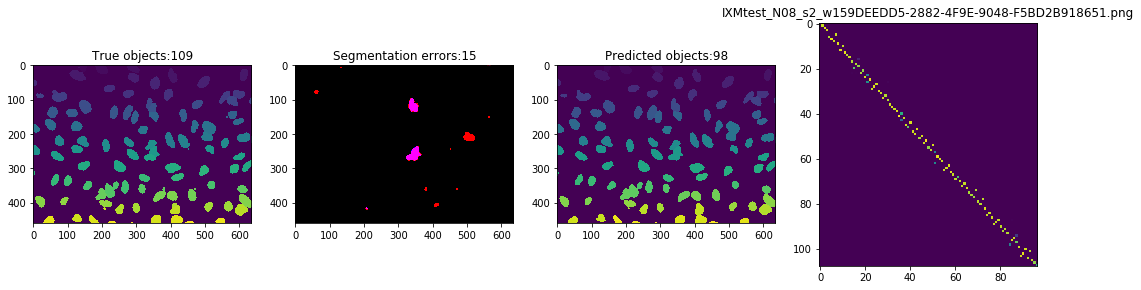

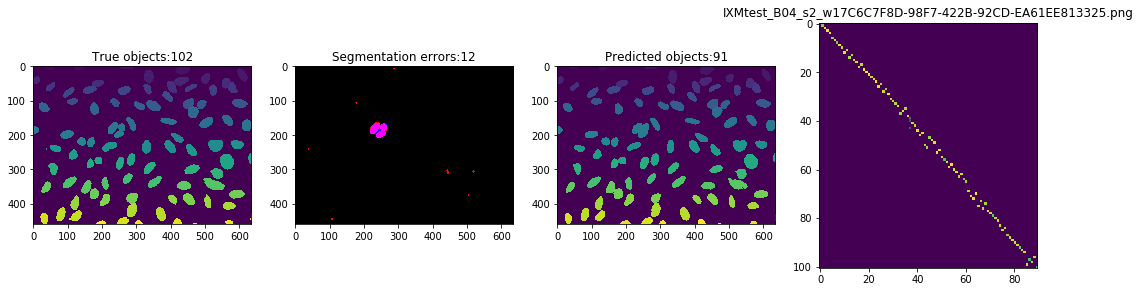

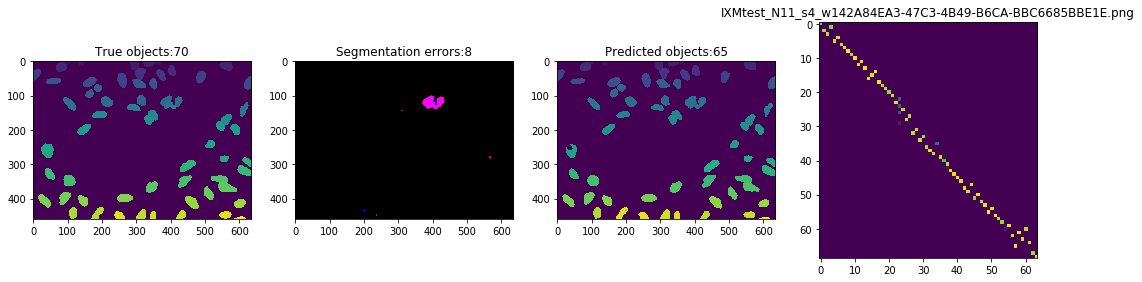

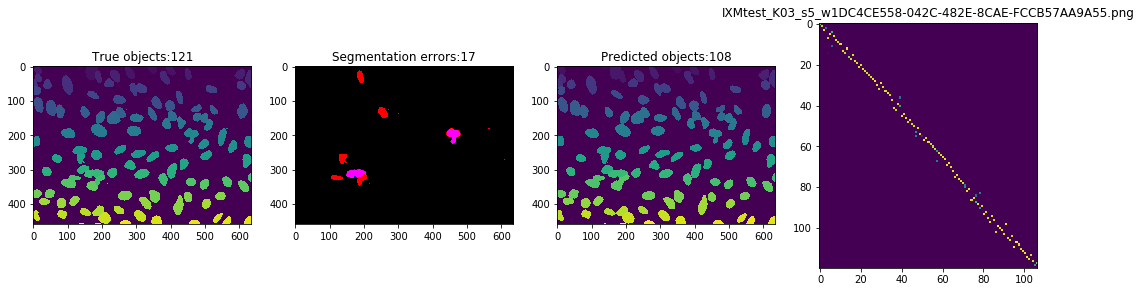

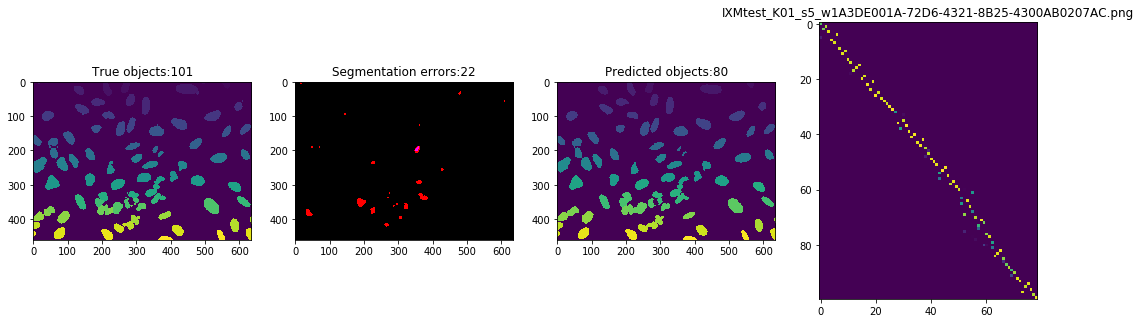

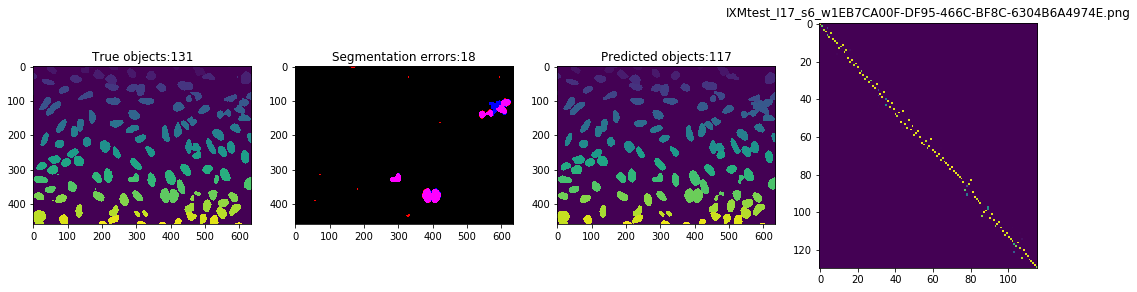

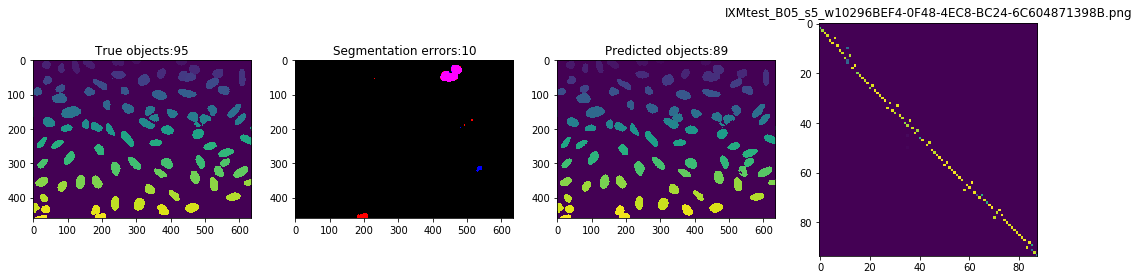

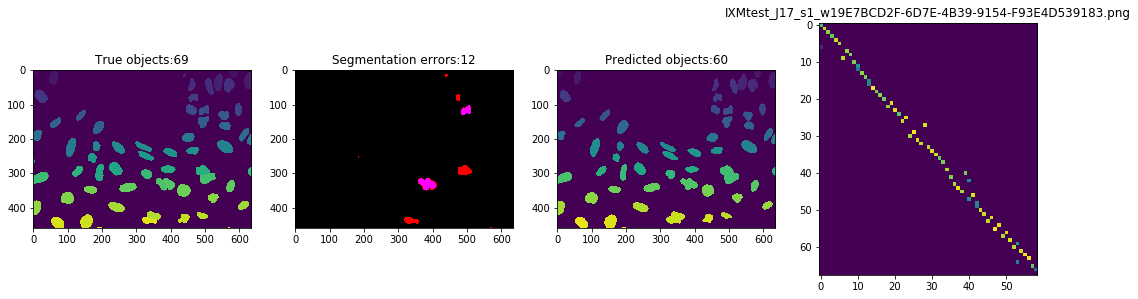

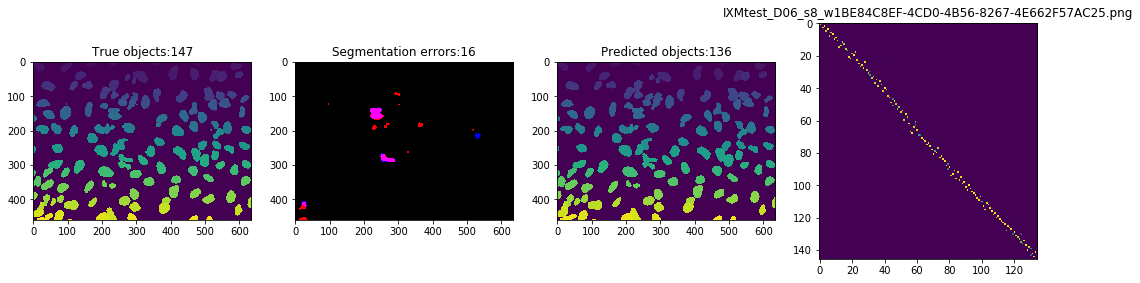

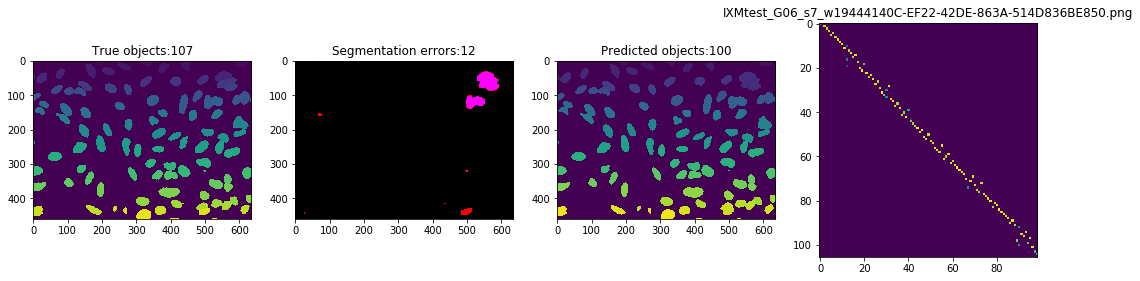

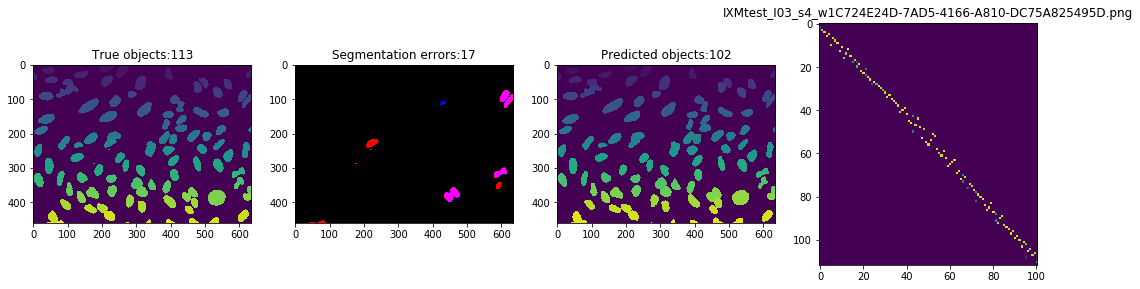

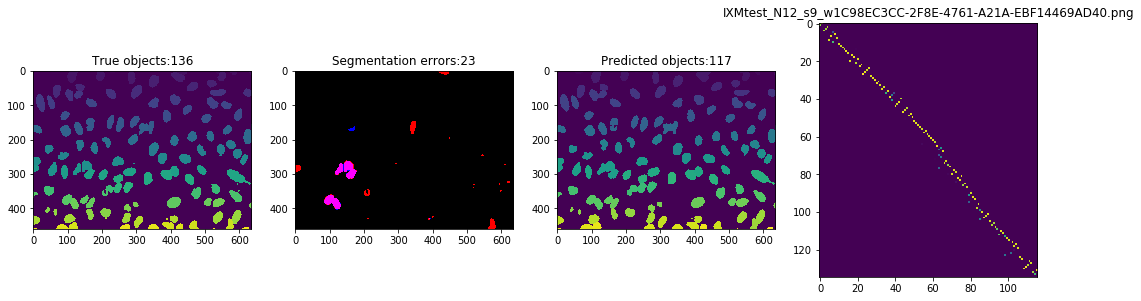

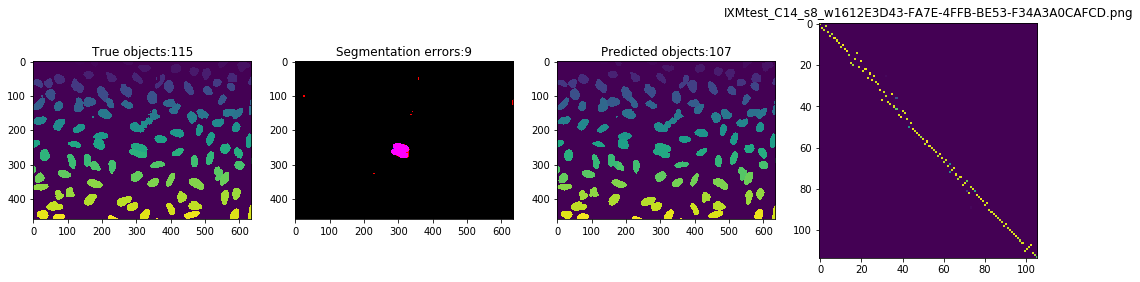

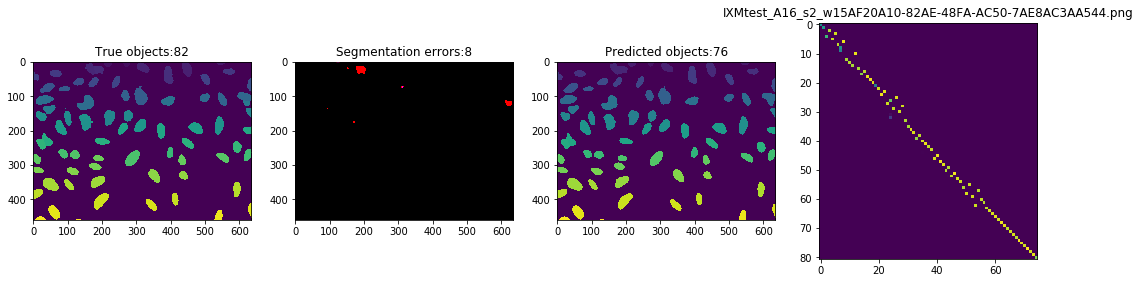

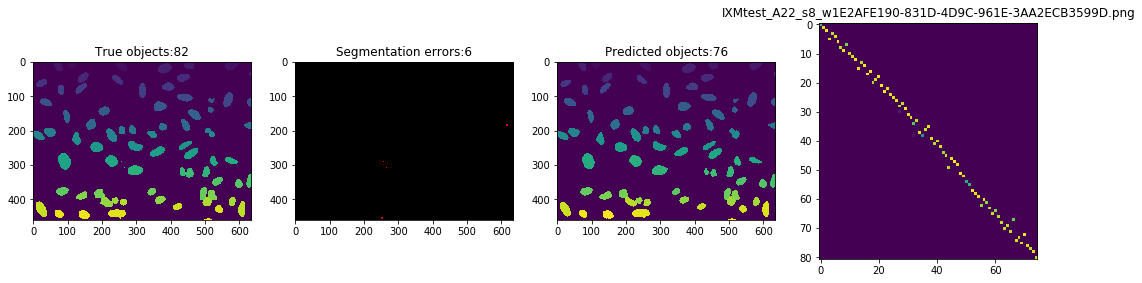

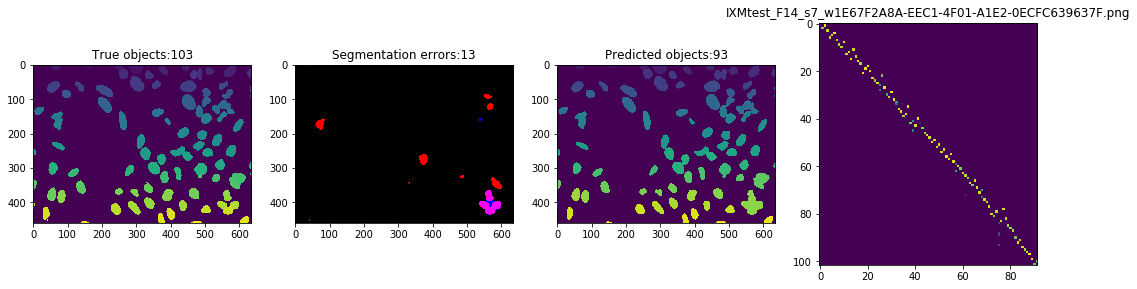

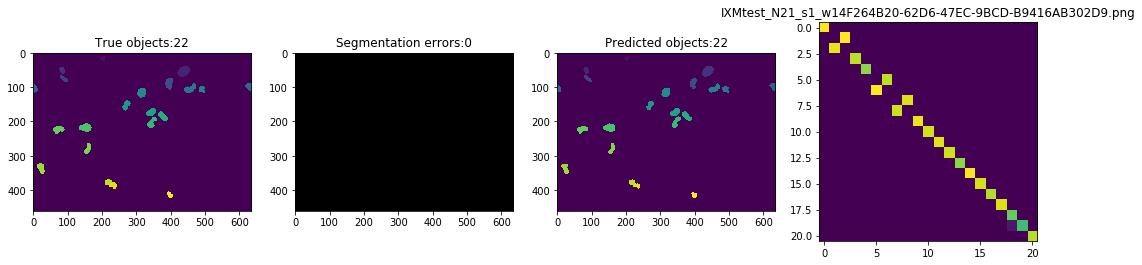

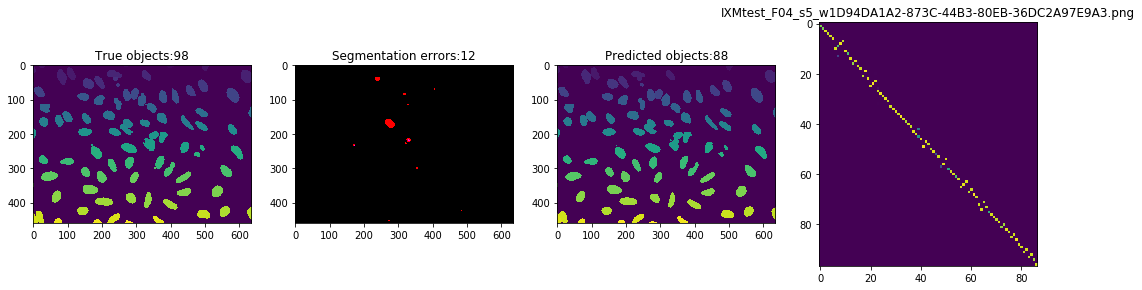

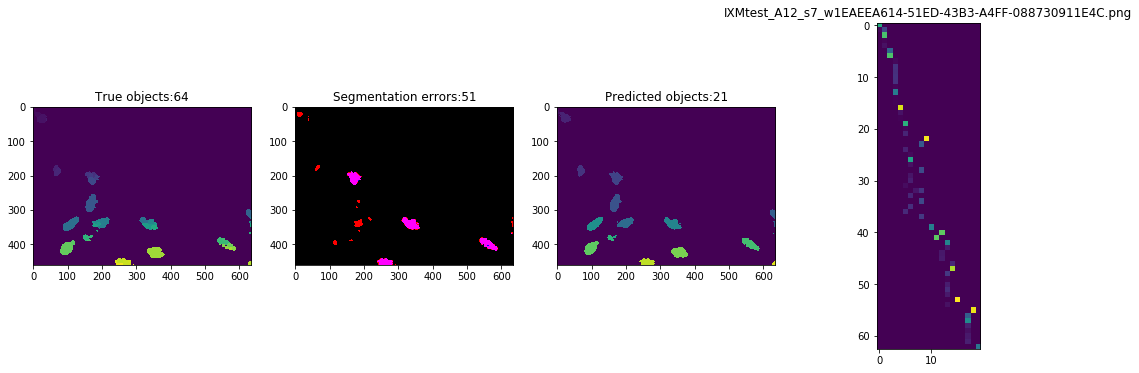

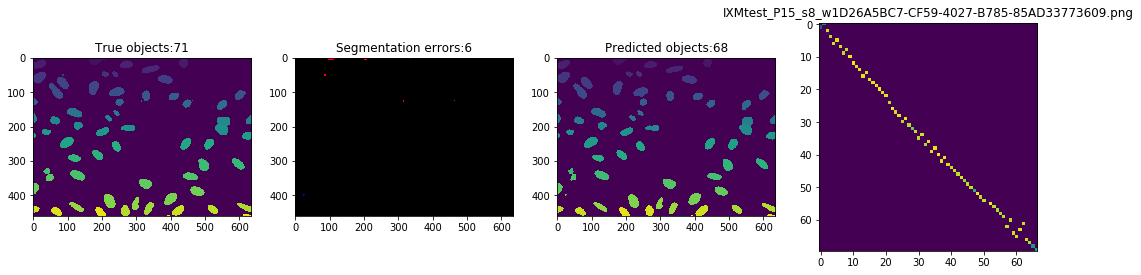

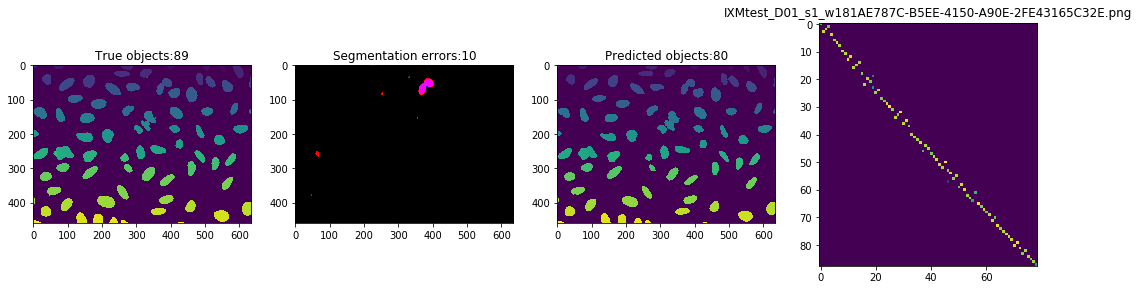

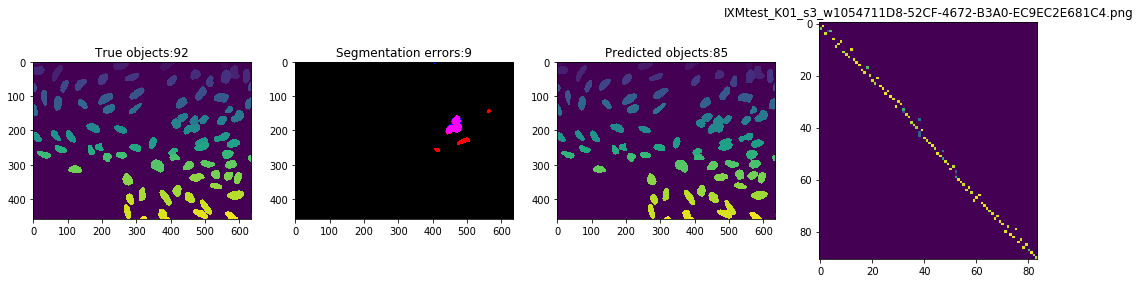

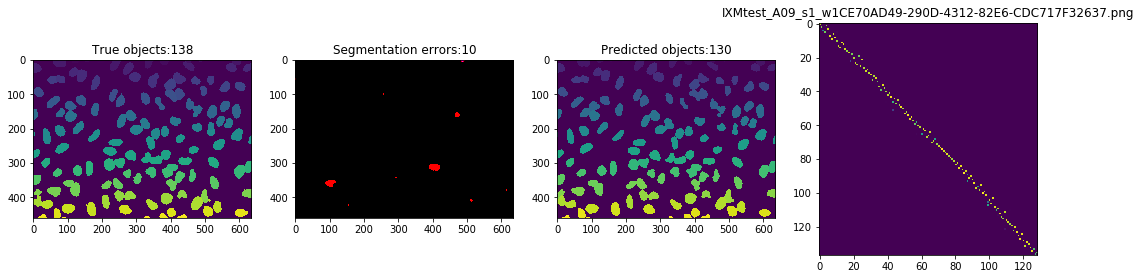

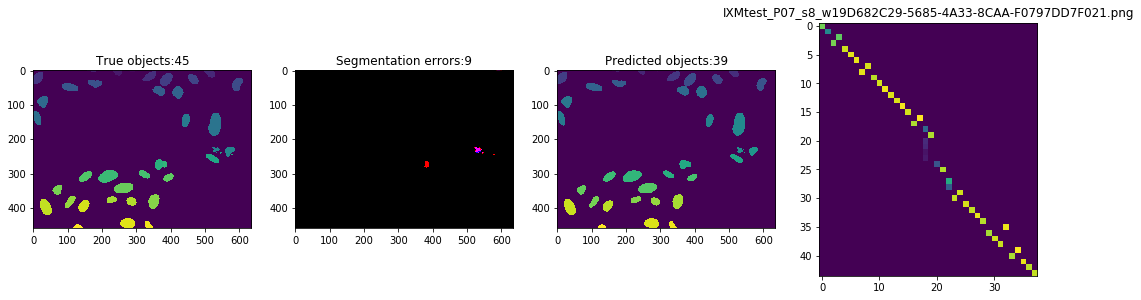

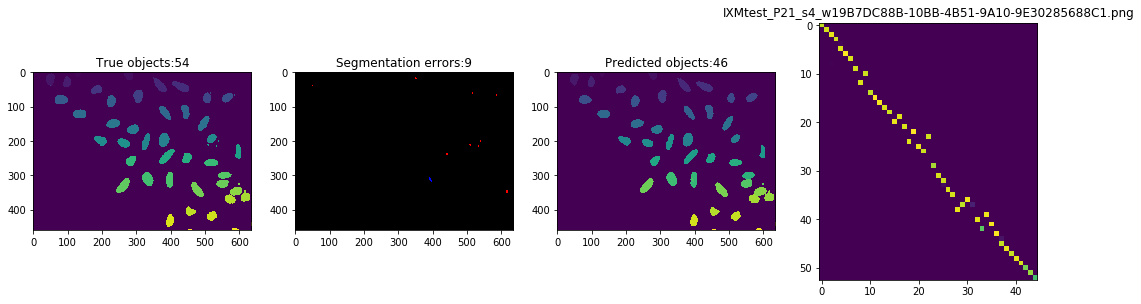

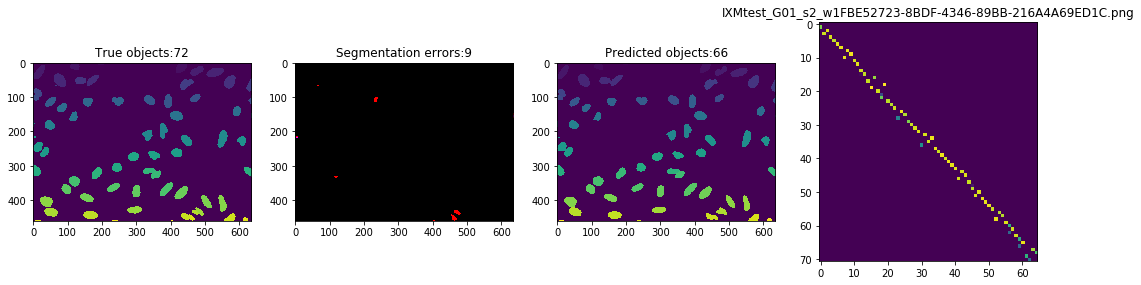

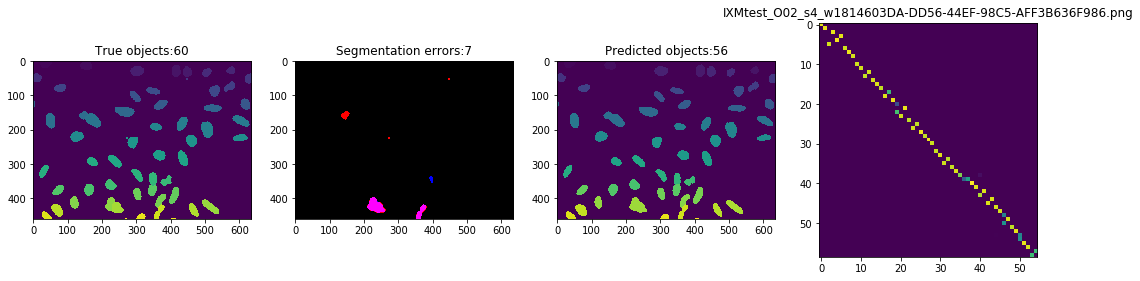

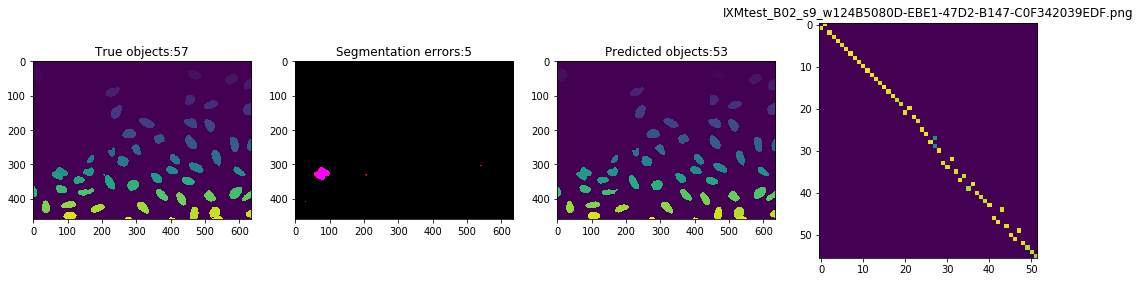

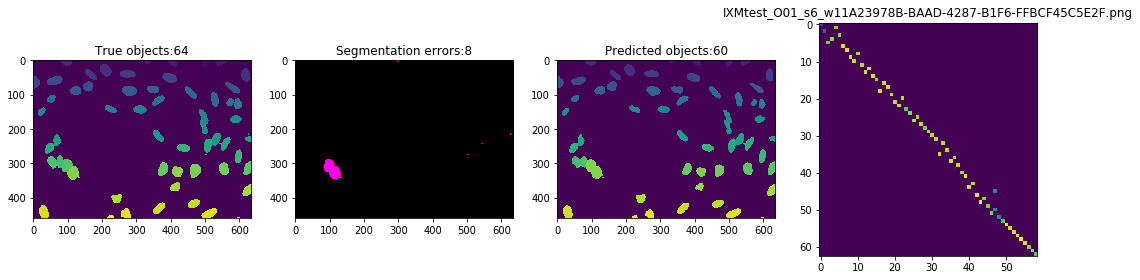

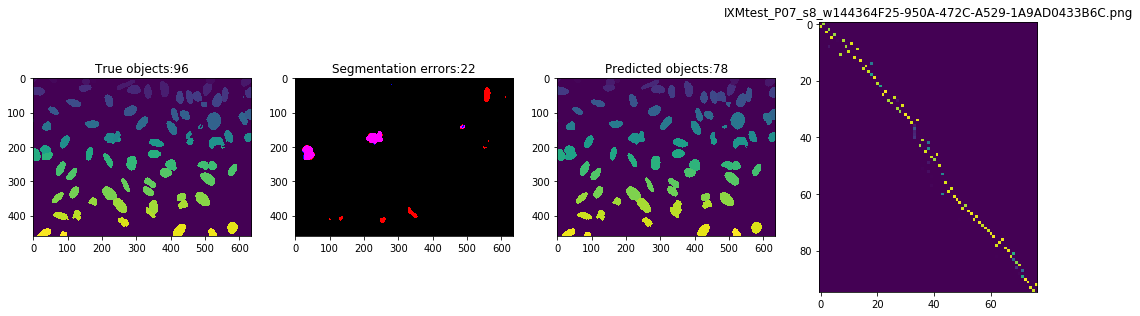

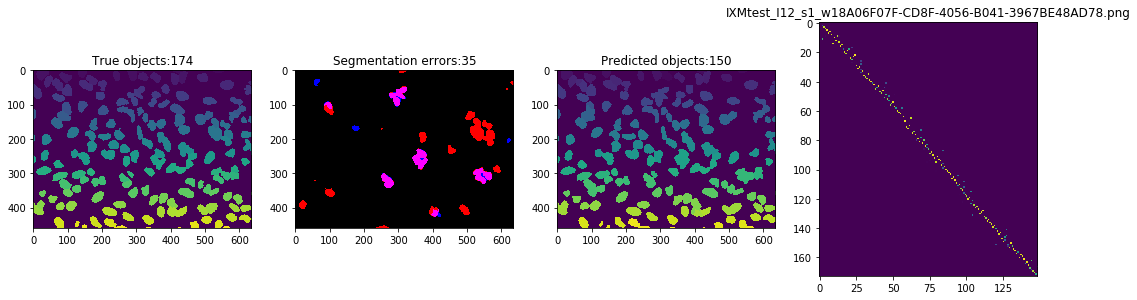

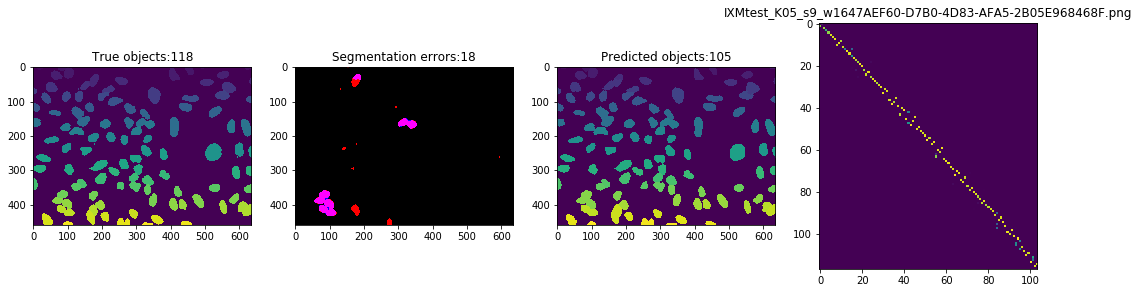

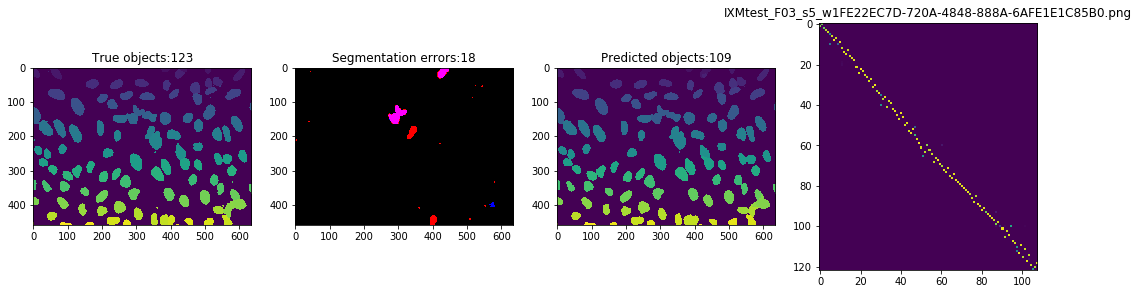

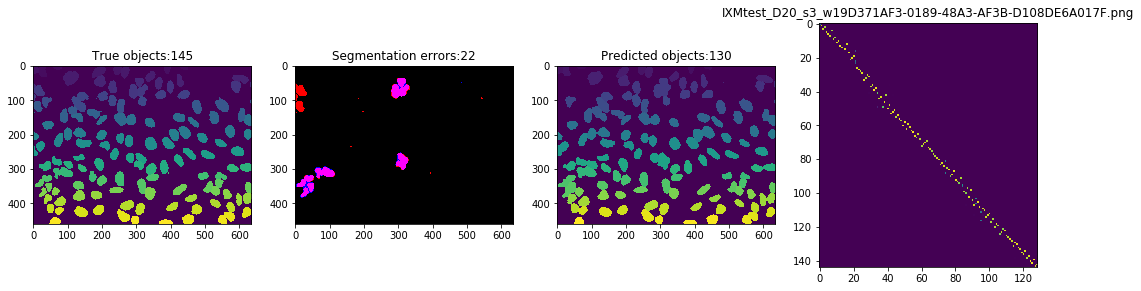

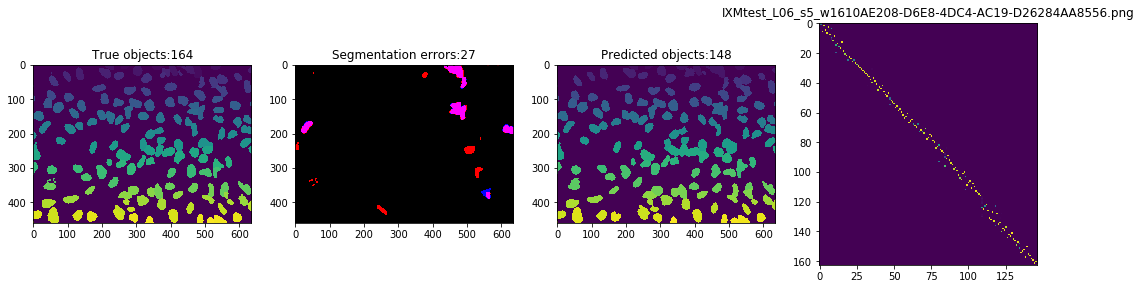

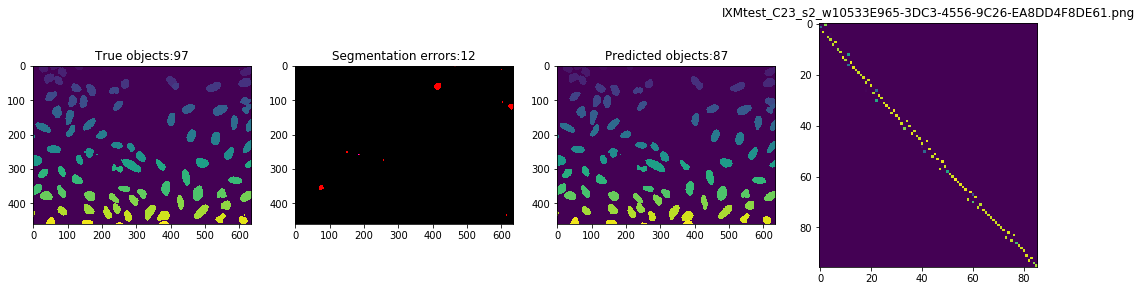

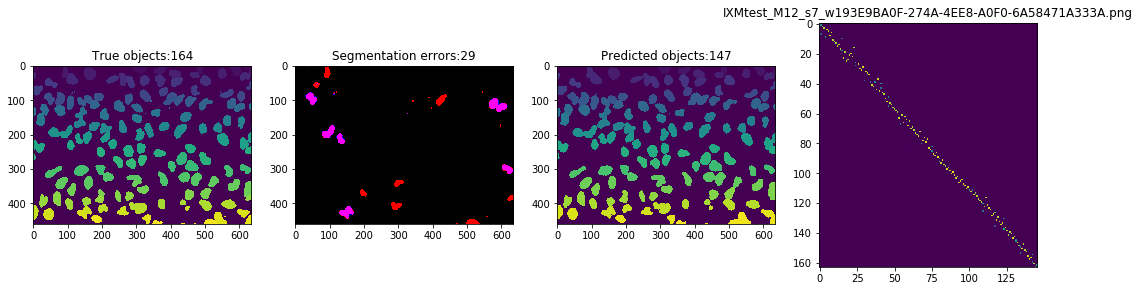

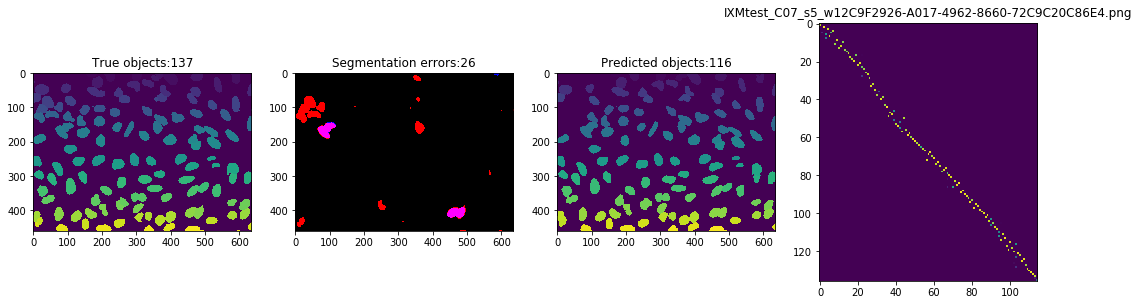

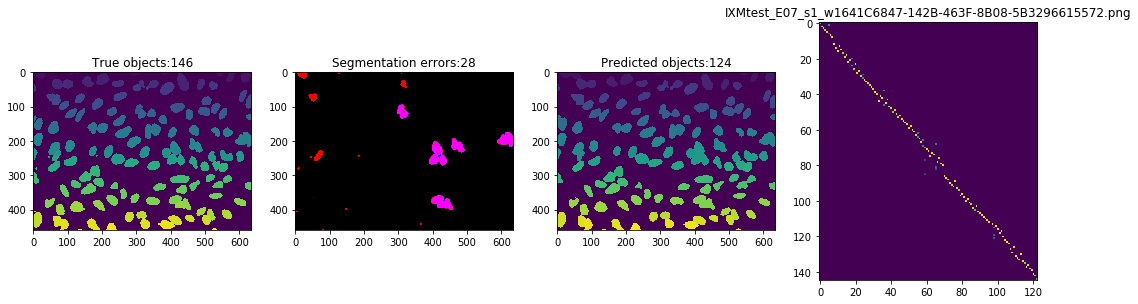

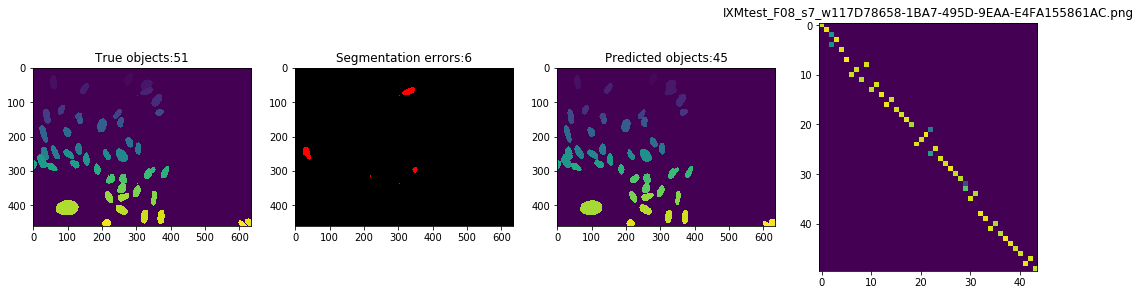

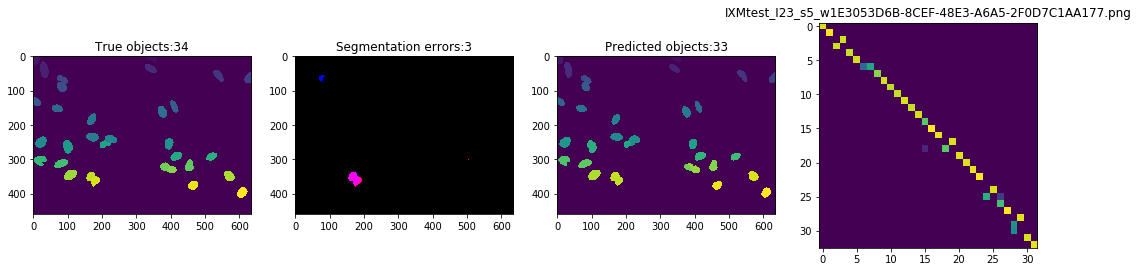

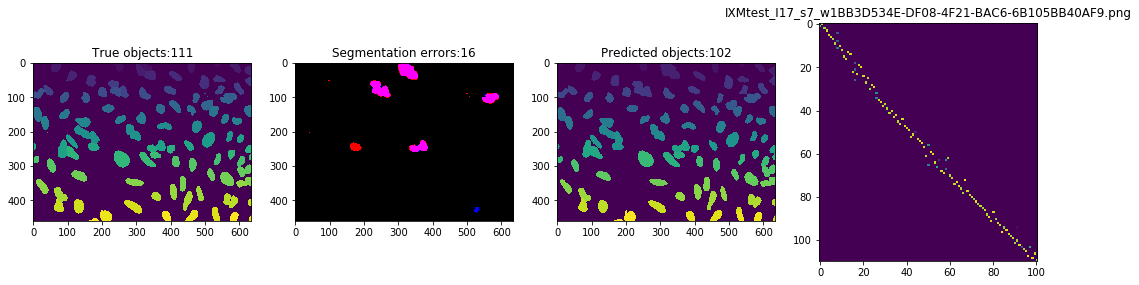

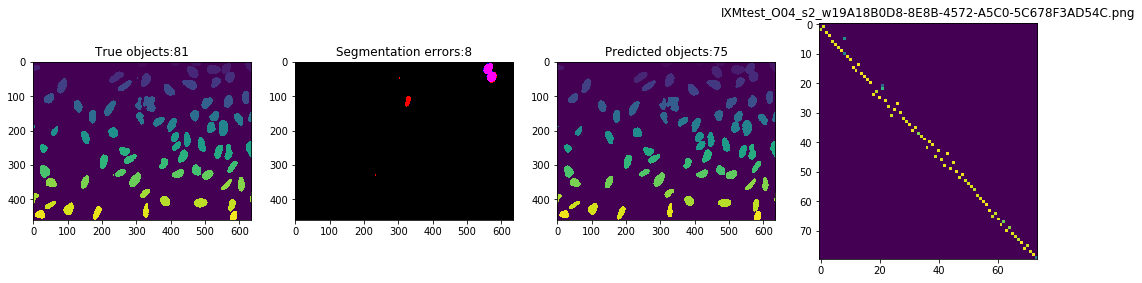

In [9]:
all_images = os.listdir(ref_out_dir_label)

results = pd.DataFrame(columns=["Image", "Threshold", "Precision"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges","Splits"])

for image_name in all_images:
    # Load ground truth data
    ground_truth = skimage.io.imread(dir_gtruth + image_name)
    
    # Transform to label matrix
    ground_truth = skimage.morphology.label(ground_truth[:,:,0])
    
    # Load predictions
    #prediction = skimage.io.imread(out_dir_label + image_name) #unet
    #prediction = skimage.io.imread(out_dir_label + image_name.replace(".png",".tif")) #deepcell
    prediction = skimage.io.imread(out_dir_label + image_name.replace(".png",".tiff")) #cellprofiler
    #prediction = skimage.morphology.dilation(prediction, skimage.morphology.square(dilation_parameter))
    
    # Compute evaluation metrics
    #results = compute_results(ground_truth, prediction, results)
    results = compute_results(
        skimage.segmentation.relabel_sequential(ground_truth[30:-30,30:-30])[0], 
        skimage.segmentation.relabel_sequential(prediction[30:-30,30:-30])[0], 
        results, image_name) # deepcell
    
    false_negatives = get_false_negatives(
        skimage.segmentation.relabel_sequential(ground_truth[30:-30,30:-30])[0], 
        skimage.segmentation.relabel_sequential(prediction[30:-30,30:-30])[0], 
        false_negatives, image_name) # deepcell

    splits_merges = get_splits_and_merges(
        skimage.segmentation.relabel_sequential(ground_truth[30:-30,30:-30])[0], 
        skimage.segmentation.relabel_sequential(prediction[30:-30,30:-30])[0], 
        splits_merges, image_name) # deepcell

In [10]:
# Display average precision results
average_precision = results.groupby("Threshold").mean().reset_index()
average_precision

,Threshold,Precision
0,0.50,0.828231
1,0.55,0.809121
2,0.60,0.788856
3,0.65,0.776592
4,0.70,0.755671
5,0.75,0.724370
6,0.80,0.665861
7,0.85,0.563064
8,0.90,0.252104
9,0.95,0.016041


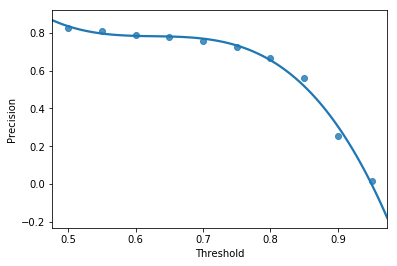

In [11]:
# Plot average precision results
sb.regplot(data=average_precision, x="Threshold", y="Precision", order=3, ci=None)

In [12]:
# Compute and print Mean Average Precision
mean_average_precision = average_precision["Precision"].mean()
print("MAP:", mean_average_precision)

MAP: 0.617991002823


In [13]:
# Summarize False Negatives by area
false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Micronuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Micronuclei      504
Small nuclei     276
Normal nuclei    115
Large nuclei      25
Name: False_Negative, dtype: int64

In [14]:
# Summarize splits and merges
print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 13
Merges: 142
